# \[Working Draft] Exploratory Data Analysis for Data Driven Modelling

Welcome to using the data driven jupyter notebook for evaluating if data from csv file(s) is sufficient for creating simulators using supervised learning methods. The approach of learning the state transitions,  $(s, a) \rightarrow s'$ from data is growing in popularity, however, not all of your data may have the correct distributions for the ranges needed for your Reinforcement Learning use case.

Here are some key assumptions about your data:
- The dataset contains:
    * States
    * Actions
    * Configs (optional)
    * Episode
    * Iteration
- All columns are numeric
- Episodes always start with iteration 0
- There should be no gaps in iterations

In [1]:
# Imports Libraries
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_dd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from hydra.experimental import compose, initialize_config_dir
from omegaconf import OmegaConf
sns.set_context(rc={'grid.linewidth': 0})

In [2]:
# Sets directory path to parent folder of the notebook
dir_path = os.path.dirname(os.getcwd())
os.chdir(dir_path)
# Reads the config file
with initialize_config_dir(config_dir=os.path.join(dir_path, 'conf')):
    cfg = compose(config_name='config', overrides=[])

In [3]:
# Generates the data path
data_path = os.path.join(dir_path, cfg['data']['path'])
# Reads into a pandas dataframe
df = pd.read_csv(data_path)
# Prints 5 random rows
df.sample(5)

,state_x_position,state_x_velocity,state_angle_position,state_angle_velocity,action_command,config_length,config_masspole,episode,iteration
341754,0.035750,0.181230,0.010613,-0.315920,1,0.5,0.1,6835,4
455281,0.097910,-0.333891,-0.424939,-0.971705,0,0.5,0.1,9105,31
367891,-0.099876,0.052931,-0.064361,-0.528633,1,0.5,0.1,7357,41
268303,-0.033111,0.031694,0.000825,0.002446,0,0.5,0.1,5366,3
261016,0.005792,-0.537412,-0.125918,0.411325,0,0.5,0.1,5220,16


In [4]:
# Saves a record of episode counts pre removal of nulls
init_episode_count = df['episode'].nunique()
# Converts all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')
# Removes rows with null values
df.dropna(inplace=True)
# Calculates episode counts
episodes = df.groupby('episode').agg(first_iteration=('iteration', 'min'),
                                     last_iteration=('iteration', 'max'),
                                     iteration_count=('iteration', 'count')
                                     ).reset_index(drop=True)
# Valid episodes are where the first iteration is 0 and there are no gaps in iterations
valid_episodes = episodes.index[episodes['first_iteration'] == 0 &
                                (episodes['last_iteration'] - episodes['first_iteration'] + 1 == episodes['iteration_count'])]
# Drops all rows with invalid episodes
df.drop(df.loc[~df['episode'].isin(valid_episodes)].index, inplace=True)
# Resets the index
df.reset_index(drop=True, inplace=True)
# Print
print('Removed {} invalid episode(s)'.format(init_episode_count-len(valid_episodes)))

Removed 0 invalid episode(s)


In [5]:
# Prints basic counts
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print('Number of episodes:', df['episode'].nunique())
# Calculates Episode Lengths (max value of 'iteration')
episode_lengths = df.groupby('episode')['iteration'].count()
print('Shortest episode: {} iteration(s)'.format(episode_lengths.min()))
print('Longest episode: {} iteration(s)'.format(episode_lengths.max()))

Number of rows: 500000
Number of columns: 9
Number of episodes: 10000
Shortest episode: 50 iteration(s)
Longest episode: 50 iteration(s)


In [6]:
# States (modify if states don't start with 'state')
state_vars = [x for x in df.columns if x.startswith('state')]
# Actions (modify if actions don't start with 'action')
action_vars = [x for x in df.columns if x.startswith('action')]
# Configs (modify if configs don't start with 'config')
config_vars = [x for x in df.columns if x.startswith('config')]

print('Dataset contains: {} state(s), {} action(s) and {} config(s)'.format(len(state_vars), len(action_vars), len(config_vars)))

Dataset contains: 4 state(s), 1 action(s) and 2 config(s)


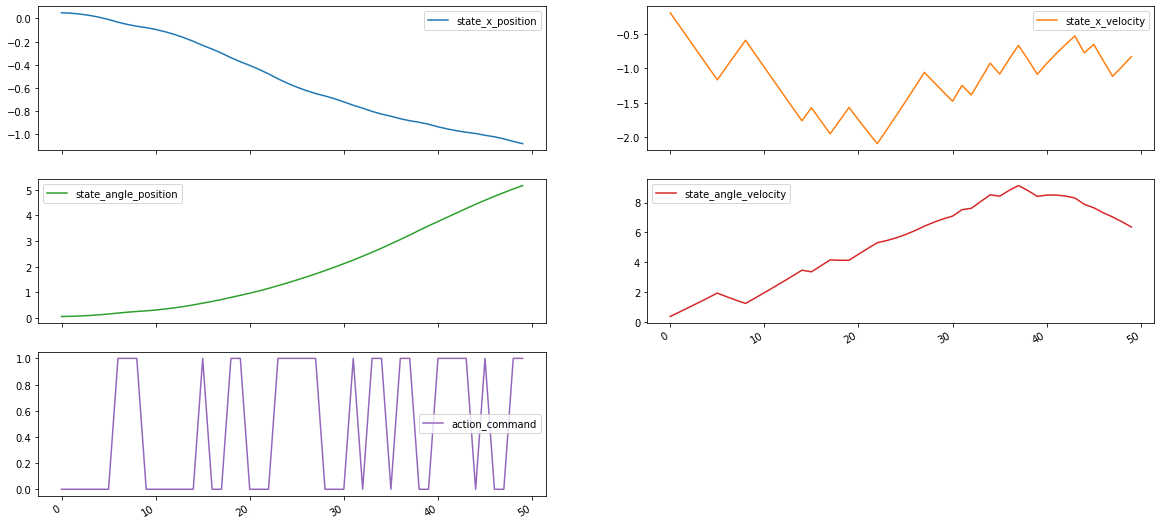

In [7]:
# Plots states and actions of a random episode
random_episode = random.choice(df['episode'])
random_day_data = df.loc[df['episode'] == random_episode, state_vars+action_vars].reset_index(drop=True)
random_day_data.plot(subplots=True, figsize=(20,10), layout=(-1,2));

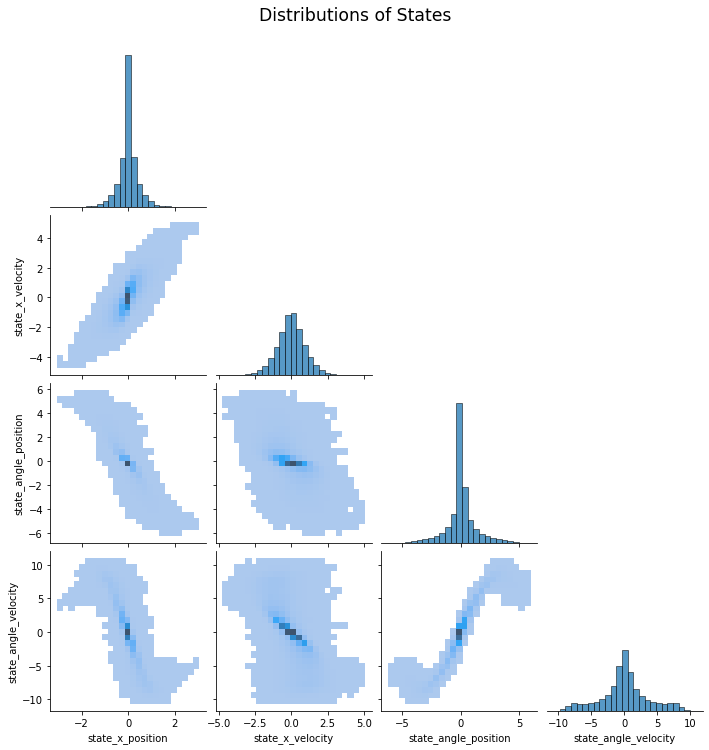

In [8]:
# Plots the distributions of States
g = sns.pairplot(df[state_vars], kind='hist', diag_kind='hist', corner=True, plot_kws = {'bins':25}, diag_kws = {'bins':25})
g.fig.suptitle('Distributions of States', size = 'xx-large', y=1.04);

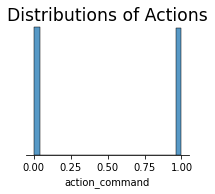

In [9]:
# Plots the distributions of Actions
g = sns.pairplot(df[action_vars], kind='hist', diag_kind='hist', corner=True, plot_kws = {'bins':25}, diag_kws = {'bins':25})
g.fig.suptitle('Distributions of Actions', size = 'xx-large', y=1.04);

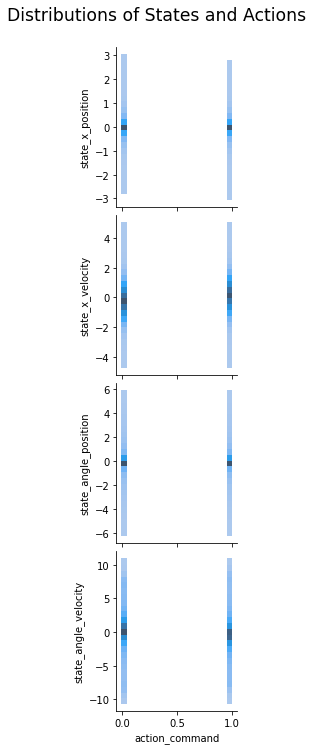

In [10]:
# Plots the distributions of States and Actions
g = sns.pairplot(df, x_vars=action_vars, y_vars=state_vars, kind='hist', diag_kind=None, plot_kws = {'bins':25})
g.fig.suptitle('Distributions of States and Actions', size = 'xx-large', y=1.04);